In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
### JUPYTER NOTEBOOK EAGER LOAD ###
import io, os, sys, types, re
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def get_chapter_number(file_name):
    hit = re.match(r'(?P<chapter>\d+)\..*', file_name)
    return int(hit['chapter'])

files = !ls *.ipynb
files = sorted(files, key=lambda f: int(f.split('.')[0]))
files = filter(lambda file: get_chapter_number(file) < get_chapter_number(theNotebook), files)

nbs = []
for file in files:
    with io.open(file, 'r', encoding='utf-8') as f:
        nbs.append(read(f, 4))

each_code_cells = []
for nb in nbs:
    each_code_cells.append(filter(lambda c: c['cell_type'] == 'code', nb.cells))

for code_cells in each_code_cells:
    for code_cell in code_cells:
        code = InteractiveShell.instance().input_transformer_manager.transform_cell(code_cell.source)
        try:
            if code.split("\n")[0] == '### JUPYTER NOTEBOOK EAGER LOAD ###': continue
            get_ipython().run_cell_magic('capture', '', code)
        except RuntimeError:
            continue

In [3]:
%%latex
$H(s) = -p_1log_2p_1 - ... -p_nlog_2p_n$

<IPython.core.display.Latex object>

In [20]:
def entropy(probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in probabilities if p)

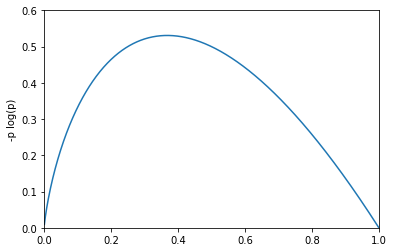

In [21]:
xs = [x * .001 for x in range(1, 1001)]
ys = [-x * math.log(x, 2) for x in xs]
plt.xlim(0, 1)
plt.ylim(0, 0.6)
plt.ylabel('-p log(p)')
plt.plot(xs, ys)
plt.show()

In [22]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels= [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

In [23]:
%%latex
$H = q_1H(S_1) + ... + q_mH(S_m)$

<IPython.core.display.Latex object>

In [24]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets
    subsets is a list of lists of labeled data"""
    
    total_count = sum(len(subset) for subset in subsets)
    
    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

In [25]:
inputs = [
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
        ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
        ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
        ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
        ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
        ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
        ]

In [26]:
def partition_by(inputs, attribute):
    """each input is a pair (attribute_dict, label).
    returns a dict : attribute_value -> inputs"""
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the value of specified attribute
        groups[key].append(input) # then add this input to the correct list
    return groups

In [27]:
def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

In [37]:
for key in inputs[0][0].keys():
    print(key, partition_entropy_by(inputs, key))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


In [67]:
senior_inputs = [(input, label)
                 for input, label in inputs if input['level'] == 'Senior']

for key in inputs[0][0].keys():
    if key != 'level':
        print(key, partition_entropy_by(senior_inputs, key))

lang 0.4
tweets 0.0
phd 0.9509775004326938


In [38]:
junior_inputs = [(input, label)
                 for input, label in inputs if input['level'] == 'Junior']

for key in inputs[0][0].keys():
    if key != 'level':
        print(key, partition_entropy_by(junior_inputs, key))

lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


In [58]:
tree_in_hand= ('level',
                  {'Junior': ('phd',{'no': True, 'yes': False}),
                   'Mid': True,
                   'Senior': ('tweets', {'no': False, 'yes': True})})
tree_in_hand

('level',
 {'Junior': ('phd', {'no': True, 'yes': False}),
  'Mid': True,
  'Senior': ('tweets', {'no': False, 'yes': True})})

In [61]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    
    # if this is a leaf noe , return its value
    if tree in [True, False]:
        return tree
    
    # otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)  # None if input is missing attribute
    
    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree
        
    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input

In [51]:
def build_tree_id3(inputs, split_candidates=None):
    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
        
    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    if num_trues == 0: return False    # no Trues? return a "False" leaf
    if num_falses == 0: return True    # no Falses? return a "True" leaf
    
    if not split_candidates:           # if no split candidates left
        return num_trues >= num_falses # return the majority leaf
    
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
                         key=partial(partition_entropy_by, inputs))
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = {attribute_value: build_tree_id3(subset, new_candidates)
                for attribute_value, subset in partitions.items()}
    
    subtrees[None] = num_trues > num_falses # default case
    
    return (best_attribute, subtrees)

In [56]:
tree = build_tree_id3(inputs)
tree # attribute `None` is added

('level',
 {'Junior': ('phd', {None: True, 'no': True, 'yes': False}),
  'Mid': True,
  None: True,
  'Senior': ('tweets', {None: False, 'no': False, 'yes': True})})

In [62]:
classify(tree, {"level" : "Junior",
          "lang": "Java",
          "tweets": "yes",
          "phd": "no"})

True

In [63]:
classify(tree,{"level": "Junior",
               "lang": "Java",
               "tweets" : "yes",
               "phd": "yes"})

False

In [64]:
classify(tree, {'level': 'Intern'})

True

In [65]:
classify(tree, {'level': 'Senior'})

False